In [1]:
import torch
import torch.optim as optim
import time
import numpy as np
import matplotlib.pyplot as plt
from utils import data_processing, visualization, statistic
import time
import pandas as pd
import warnings
import sksurv as sks
from sksurv.nonparametric import kaplan_meier_estimator#
warnings.filterwarnings("ignore")

In [2]:
dataset_name = "AIDS_Clinical_Trials_Group"
data_file= "dataset/" + dataset_name + "/HIV_control_v2.csv"
feat_types_file = "dataset/" + dataset_name + "/data_types_v2.csv"
miss_file = "dataset/" + dataset_name + "/Missings_v2.csv"
true_miss_file = None

In [3]:
HIV_control = pd.read_csv(data_file,header=None)
HIV_control.head()

,0,1,2,3,4,5,6,7,8,9,10
0,1,1,1,1,0,100,169.0,39.0,34,0,189
1,1,2,2,1,0,90,149.5,15.0,34,0,287
2,1,1,1,1,0,90,46.0,53.0,48,0,199
3,1,1,2,1,0,100,54.5,6.0,51,0,270
4,1,1,1,1,0,100,95.0,7.0,34,0,276


In [5]:
pd.read_csv(miss_file,header=None)

,0,1
0,1,10
1,2,10
2,3,10
3,4,10
4,5,10
...,...,...
572,573,10
573,574,10
574,575,10
575,576,10


### Data loading and Feature analysis

In [15]:
# Load training data
data, feat_types_dict, miss_mask, true_miss_mask, n_samples = data_processing.read_data(data_file, feat_types_file, miss_file, true_miss_file)

In [23]:
data[0:5,:]

tensor([[  0.0000,   1.0000,   1.0000,   0.0000,   1.0000,   0.0000,   0.0000,
           0.0000,   0.0000,   1.0000,   0.0000,   0.0000,   1.0000,   0.0000,
           0.0000,   0.0000,   0.0000,   1.0000, 169.0000,  39.0000,  34.0000,
           1.0000, 190.0000],
        [  0.0000,   1.0000,   0.0000,   1.0000,   0.0000,   1.0000,   0.0000,
           0.0000,   0.0000,   1.0000,   0.0000,   0.0000,   1.0000,   0.0000,
           0.0000,   0.0000,   1.0000,   0.0000, 149.5000,  15.0000,  34.0000,
           1.0000, 288.0000],
        [  0.0000,   1.0000,   1.0000,   0.0000,   1.0000,   0.0000,   0.0000,
           0.0000,   0.0000,   1.0000,   0.0000,   0.0000,   1.0000,   0.0000,
           0.0000,   0.0000,   1.0000,   0.0000,  46.0000,  53.0000,  48.0000,
           1.0000, 200.0000],
        [  0.0000,   1.0000,   1.0000,   0.0000,   0.0000,   1.0000,   0.0000,
           0.0000,   0.0000,   1.0000,   0.0000,   0.0000,   1.0000,   0.0000,
           0.0000,   0.0000,   0.0000,   

In [24]:
miss_mask[0:5,:]

tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1.]])

### Experiment setting

In [18]:
prop_keep =0.2
rng = np.random.default_rng()
select = rng.binomial(1,prop_keep,data.shape[0])
data_keep = data[select==1]
miss_mask_keep = miss_mask[select==1]
true_miss_mask_keep = true_miss_mask[select==1]

In [19]:
train_test_share = .99
n_samples = data_keep.shape[0]
n_train_samples = int(train_test_share * n_samples)
train_index = np.random.choice(n_samples, n_train_samples, replace=False)
print(len(train_index))
test_index = [i for i in np.arange(n_samples) if i not in train_index]

121


In [20]:
# Train-test split
data_keep_train = data_keep[train_index]
miss_mask_keep_train = miss_mask_keep[train_index]
true_miss_mask_keep_train = true_miss_mask_keep[train_index]

data_keep_test = data_keep[test_index]
miss_mask_keep_test = miss_mask_keep[test_index]
true_miss_mask_keep_test = true_miss_mask_keep[test_index]

# Adjust batch size if larger than dataset
batch_size = 100
batch_size = min(batch_size, n_train_samples)

# Number of batches
n_train_samples = data_keep_train.shape[0]
n_batches_train = int(np.floor(n_train_samples / batch_size))
n_train_samples = n_batches_train * batch_size

# Compute real missing mask
miss_mask_train = torch.multiply(miss_mask_keep_train, true_miss_mask_keep_train)

# test set
n_test_samples = data_keep_test.shape[0]

# Number of batches
n_batches_test = 1

# Compute real missing mask
miss_mask_test = torch.multiply(miss_mask_keep_test, true_miss_mask_keep_test)

# Back to original values
data_train_transformed = data_processing.discrete_variables_transformation(data_keep_train, 
                                                                           feat_types_dict)
data_test_transformed = data_processing.discrete_variables_transformation(data_keep_test, 
                                                                           feat_types_dict)

### Model loading

In [21]:
import importlib
import os 

# model_name="HIVAE_factorized"
model_name="HIVAE_inputDropout"
dim_latent_z = 10
dim_latent_y = 5
dim_latent_s = 5
epochs = 1000
lr = 1e-3
save_file= "{}_{}_z{}_y{}_s{}_batch_{}".format(model_name, dataset_name,  dim_latent_z, dim_latent_y, dim_latent_s, batch_size)
# Create directories for saving models
save_dir = f'./saved_networks/{save_file}/'
os.makedirs(save_dir, exist_ok=True)
network_file = os.path.join(save_dir, f'{save_file}.pth')

# Create PyTorch HVAE model
model_loading = getattr(importlib.import_module("src"), model_name)
vae_model = model_loading(input_dim=data_keep_train.shape[1], 
                          z_dim=dim_latent_z, 
                          y_dim=dim_latent_y, 
                          s_dim=dim_latent_s, 
                          y_dim_partition=None, 
                          feat_types_file=feat_types_file)

optimizer = optim.Adam(vae_model.parameters(), lr=lr)

### Train model

In [22]:
start_time = time.time()
loss_train, error_observed_train, error_missing_train = [], [], []
error_observed_test , error_missing_test = [], []

for epoch in range(epochs):
    avg_loss, avg_KL_s, avg_KL_z = 0.0, 0.0, 0.0
    samples_list, p_params_list, q_params_list, log_p_x_total, log_p_x_missing_total = [], [], [], [], []
    tau = max(1.0 - 0.01 * epoch, 1e-3)

    # Shuffle training data
    perm = np.random.permutation(data_keep_train.shape[0])
    data_keep_train = data_keep_train[perm]
    miss_mask_train = miss_mask_keep_train[perm]
    true_miss_mask_keep_train = true_miss_mask_keep_train[perm]

    for i in range(n_batches_train):
        # Get batch data
        data_list, miss_list = data_processing.next_batch(data_keep_train, 
                                                          feat_types_dict, miss_mask_keep_train, batch_size, i)

        # Mask unknown data (set unobserved values to zero)
        data_list_observed = [data * miss_list[:, i].view(batch_size, 1) for i, data in enumerate(data_list)]


        # Compute loss
        optimizer.zero_grad()
        vae_res = vae_model.forward(data_list_observed, data_list, miss_list, tau)
        vae_res["neg_ELBO_loss"].backward()
        optimizer.step()

        with torch.no_grad():

            avg_loss += vae_res["neg_ELBO_loss"].item() / n_batches_train
            avg_KL_s += torch.mean(vae_res["KL_s"]).item() / n_batches_train
            avg_KL_z += torch.mean(vae_res["KL_z"]).item() / n_batches_train

        # Save the generated samples and estimated parameters !
        samples_list.append(vae_res["samples"])
        p_params_list.append(vae_res["p_params"])
        q_params_list.append(vae_res["q_params"])
        log_p_x_total.append(vae_res["log_p_x"])
        log_p_x_missing_total.append(vae_res["log_p_x_missing"])


    #Concatenate samples in arrays
    s_total, z_total, y_total, est_data_train = statistic.samples_concatenation(samples_list)
 

    # #Transform discrete variables back to the original values
    est_data_train_transformed = data_processing.discrete_variables_transformation(est_data_train, 
                                                                                   feat_types_dict)
    est_data_train_mean_imputed = statistic.mean_imputation(data_train_transformed[:n_train_samples], 
                                                            miss_mask_train[:n_train_samples], 
                                                            feat_types_dict)

    # Compute errors
    error_observed_samples, error_missing_samples = statistic.error_computation(data_train_transformed[:n_train_samples], 
                                                                                est_data_train_transformed[:n_train_samples],
                                                                                feat_types_dict, 
                                                                                miss_mask_keep_train[:n_train_samples])
    
    # # #Create global dictionary of the distribution parameters
    q_params_complete = statistic.q_distribution_params_concatenation(q_params_list)
    
    #Number of clusters created
    cluster_index = torch.argmax(q_params_complete['s'], 1)
    cluster = torch.unique(cluster_index)
    #print('Clusters: ' + str(len(cluster)))

    # Save average loss and error
    loss_train.append(avg_loss)
    error_observed_train.append(torch.mean(error_observed_samples))
    error_missing_train.append(torch.mean(error_missing_samples))

    #visualization.print_loss(epoch, start_time, -avg_loss, avg_KL_s, avg_KL_z)
    
    # Test set
    with torch.no_grad(): 
        samples_list = []
        for i in range(n_batches_test):
            data_list, miss_list = data_processing.next_batch(data_keep_test, feat_types_dict, 
                                                              miss_mask_keep_test, n_test_samples, i)

            # Mask unknown data (set unobserved values to zero)
            data_list_observed = [data * miss_list[:, i].view(n_test_samples, 1) for i, data in enumerate(data_list)]

            vae_res = vae_model.forward(data_list_observed, data_list, miss_list, tau=1e-3)
            samples_list.append(vae_res["samples"])
    
            #Concatenate samples in arrays
            #est_data_test = statistic.samples_concatenation(samples_list)
            #est_data_test_transformed = data_processing.discrete_variables_transformation(est_data_test, 
            #                                                                              feat_types_dict)
            est_data_test = statistic.samples_concatenation(samples_list)[-1]
            est_data_test_transformed = data_processing.discrete_variables_transformation(est_data_test, feat_types_dict)
    
    error_observed_samples_test, error_missing_samples_test = statistic.error_computation(data_test_transformed, 
                                                                                est_data_test_transformed, 
                                                                                feat_types_dict, 
                                                                                miss_mask_keep_test)
    error_observed_test.append(torch.mean(error_observed_samples_test))
    error_missing_test.append(torch.mean(error_missing_samples_test))


    print("Training finished.")

torch.save(vae_model.state_dict(), network_file)


#visualization.plot_loss_evolution(np.array(error_missing_train), title = "Error on missing data",
#                                xlabel = "Epoch", ylabel = "AvgErr")

ValueError: Expected parameter loc (Tensor of shape (2, 1)) of distribution Normal(loc: torch.Size([2, 1]), scale: torch.Size([2, 1])) to satisfy the constraint Real(), but found invalid values:
tensor([[nan],
        [nan]])

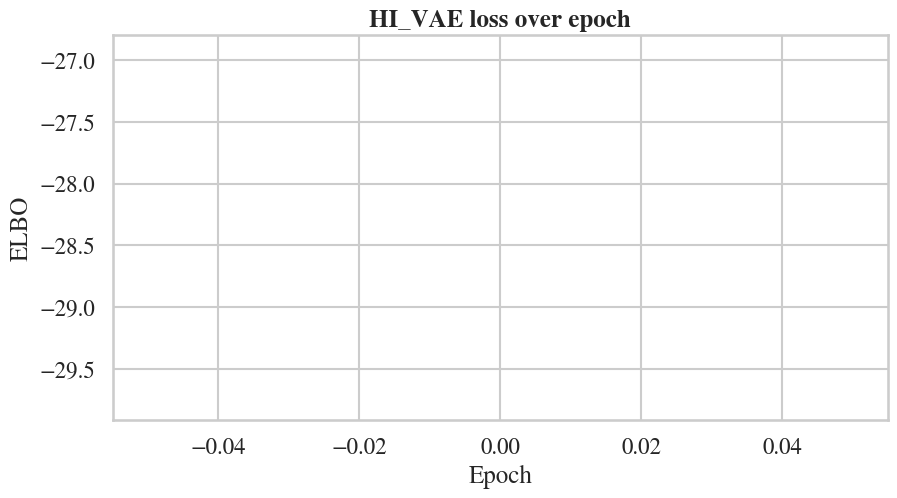

In [60]:
visualization.plot_loss_evolution(-np.array(loss_train), title = "HI_VAE loss over epoch",
                                xlabel = "Epoch", ylabel = "ELBO")


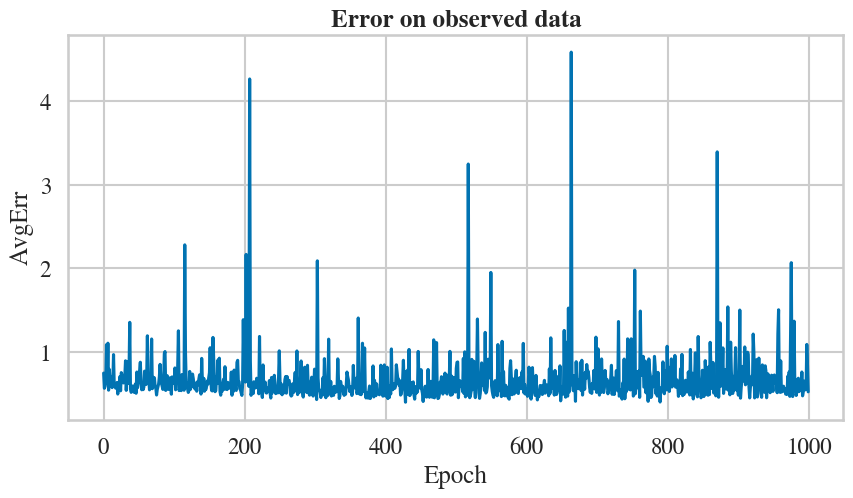

In [31]:
visualization.plot_loss_evolution(np.array(error_observed_train), title = "Error on observed data",
                                xlabel = "Epoch", ylabel = "AvgErr")


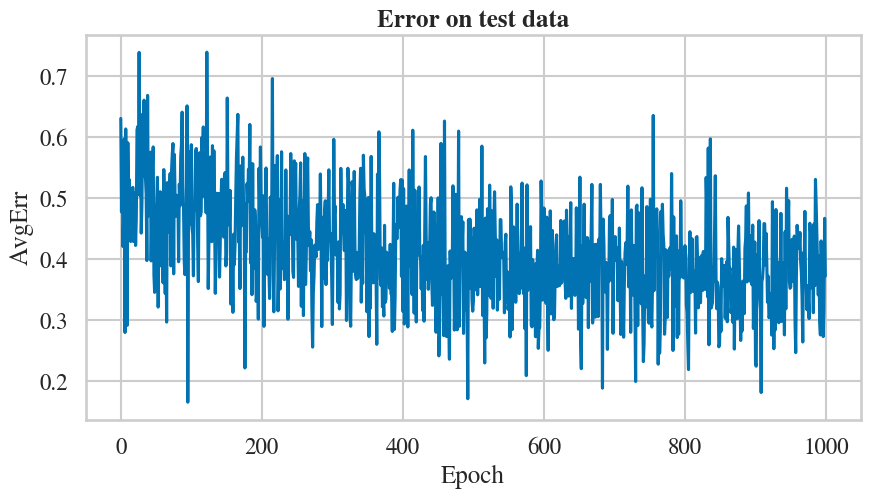

In [32]:
visualization.plot_loss_evolution(np.array(error_observed_test), title = "Error on test data",
                                xlabel = "Epoch", ylabel = "AvgErr")

# Data Generation

In [33]:
data_keep_train.shape

torch.Size([117, 23])

In [37]:
HIV_control.shape

(577, 11)

In [38]:
n_samples_generation =  HIV_control.shape[0] - data_keep_train.shape[0]
gen_index = np.random.choice( data_keep_train.shape[0], n_samples_generation , replace=True)

In [39]:
data_gen = data_keep_train[gen_index]

In [40]:
miss_mask_keep_gen = miss_mask_keep_train[gen_index]
miss_mask_keep_gen.shape

torch.Size([460, 11])

In [41]:
with torch.no_grad(): 

    data_list, miss_list = data_processing.next_batch(data_gen, feat_types_dict, 
                                                      miss_mask_keep_gen, n_samples_generation, 0)

    # Mask unknown data (set unobserved values to zero)
    data_list_observed = [data * miss_list[:, i].view(n_samples_generation, 1) for i, data in enumerate(data_list)]

    vae_res = vae_model.forward(data_list_observed, data_list, miss_list, tau=1e-3)
    samples_list.append(vae_res["samples"])

    #Concatenate samples in arrays
    #est_data_test = statistic.samples_concatenation(samples_list)
    #est_data_test_transformed = data_processing.discrete_variables_transformation(est_data_test, 
    #                                                                              feat_types_dict)
    est_data_test = statistic.samples_concatenation(samples_list)[-1]
    est_data_test_transformed = data_processing.discrete_variables_transformation(est_data_test, feat_types_dict)


In [42]:
est_data_test_transformed.shape

torch.Size([462, 11])

In [45]:
est_data_test_transformed

tensor([[  0.0000,   0.0000,   0.0000,  ...,  37.0350,  26.9010, 265.0225],
        [  1.0000,   0.0000,   2.0000,  ...,  40.3492,  26.2203, 269.4178],
        [  1.0000,   0.0000,   1.0000,  ...,  37.2264,   3.6229, 323.5412],
        ...,
        [  1.0000,   0.0000,   2.0000,  ...,  43.2375,   3.0554,  25.1915],
        [  0.0000,   0.0000,   2.0000,  ...,  41.4160,   0.0000,  22.9870],
        [  1.0000,   0.0000,   4.0000,  ...,  38.1519,   0.0000, 100.5314]])

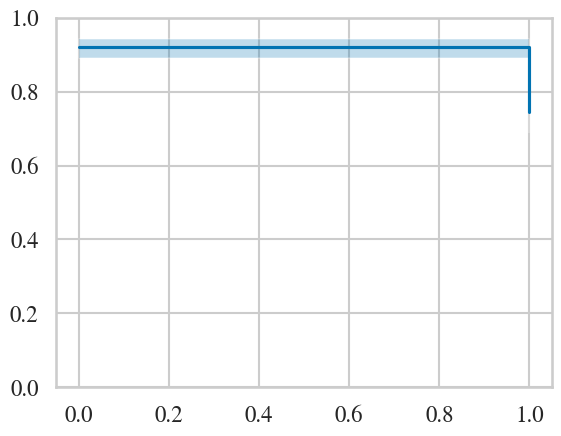

In [43]:
delta = np.array(est_data_test_transformed[:,1] , dtype=bool)
time = est_data_test_transformed[:,0]
x, y, conf_int = kaplan_meier_estimator(delta,time,
                                        conf_type="log-log")
plt.step(x, y, where="post")
plt.fill_between(x, conf_int[0], conf_int[1], alpha=0.25, step="post")
plt.ylim(0, 1)
plt.show()

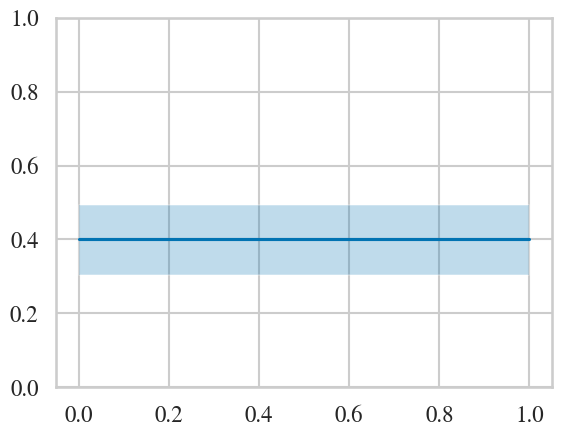

In [44]:
delta = np.array(est_data_train[:,1] , dtype=bool)
time = est_data_train[:,0]
x, y, conf_int = kaplan_meier_estimator(delta,time,
                                        conf_type="log-log")
plt.step(x, y, where="post")
plt.fill_between(x, conf_int[0], conf_int[1], alpha=0.25, step="post")
plt.ylim(0, 1)
plt.show()

In [28]:
est_data_test_transformed[:,1]

tensor([0., 0.])